<a href="https://colab.research.google.com/github/KL193/DR_Research/blob/main/DR_Metadata_Synthesis_and_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision torchaudio
!pip install pandas numpy matplotlib seaborn scikit-learn


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/My Drive/DR_Project/dataset/messidor2"


messidor_data.csv  preprocess


In [4]:
import pandas as pd

path = '/content/drive/My Drive/DR_Project/dataset/messidor2/messidor_data.csv'
df = pd.read_csv(path)
df.head()


,id_code,diagnosis,adjudicated_dme,adjudicated_gradable
0,20051020_43808_0100_PP.png,0,0,1
1,20051020_43832_0100_PP.png,1,0,1
2,20051020_43882_0100_PP.png,1,0,1
3,20051020_43906_0100_PP.png,2,1,1
4,20051020_44261_0100_PP.png,0,0,1


In [11]:
import os

image_dir = '/content/drive/My Drive/DR_Project/dataset/messidor2/preprocess'
print("Total images:", len(os.listdir(image_dir)))
print("Example images:", os.listdir(image_dir)[:5])


Total images: 1744
Example images: ['20060411_61702_0200_PP.png', '20060411_61901_0200_PP.png', '20060411_62036_0200_PP.png', '20060411_62298_0200_PP.png', '20060412_52038_0200_PP.png']


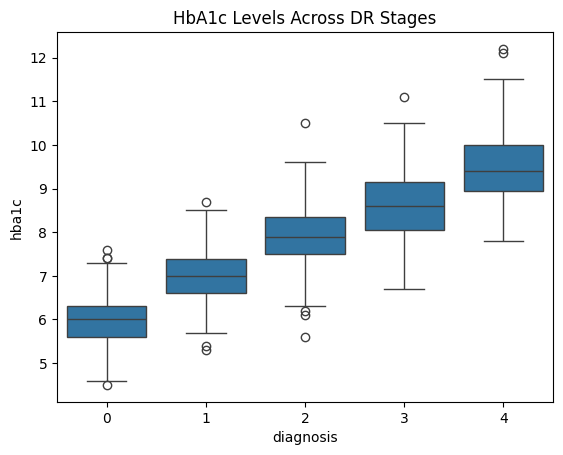

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

df = df.loc[:, ~df.columns.duplicated()]

sns.boxplot(x='diagnosis', y='hba1c', data=df)
plt.title("HbA1c Levels Across DR Stages")
plt.show()


In [9]:
import random

def generate_metadata(dr_grade):
    # Base ranges
    if dr_grade == 0:
        age = np.random.normal(45, 10)
        hba1c = np.random.normal(6.0, 0.5)
        duration = np.random.normal(3, 2)
        sbp = np.random.normal(120, 10)
    elif dr_grade == 1:
        age = np.random.normal(50, 10)
        hba1c = np.random.normal(7.0, 0.6)
        duration = np.random.normal(6, 3)
        sbp = np.random.normal(130, 12)
    elif dr_grade == 2:
        age = np.random.normal(55, 10)
        hba1c = np.random.normal(7.8, 0.7)
        duration = np.random.normal(10, 4)
        sbp = np.random.normal(140, 12)
    elif dr_grade == 3:
        age = np.random.normal(60, 8)
        hba1c = np.random.normal(8.6, 0.8)
        duration = np.random.normal(14, 5)
        sbp = np.random.normal(150, 15)
    else:
        age = np.random.normal(65, 8)
        hba1c = np.random.normal(9.4, 0.9)
        duration = np.random.normal(18, 5)
        sbp = np.random.normal(160, 15)

    return round(age,1), round(hba1c,1), round(duration,1), round(sbp,1)


metadata = df['diagnosis'].apply(lambda x: generate_metadata(x))
metadata_df = pd.DataFrame(metadata.tolist(), columns=['age','hba1c','duration','sbp'])
df = pd.concat([df, metadata_df], axis=1)
df.head()


,id_code,diagnosis,adjudicated_dme,adjudicated_gradable,age,hba1c,duration,sbp,age,hba1c,duration,sbp
0,20051020_43808_0100_PP.png,0,0,1,36.8,5.7,4.7,119.5,43.8,5.3,0.5,116.1
1,20051020_43832_0100_PP.png,1,0,1,51.4,7.0,3.5,113.5,43.9,5.9,4.0,139.9
2,20051020_43882_0100_PP.png,1,0,1,63.6,6.9,9.3,135.4,49.7,6.5,8.6,128.8
3,20051020_43906_0100_PP.png,2,1,1,50.0,8.3,5.8,118.9,52.0,8.2,11.3,156.4
4,20051020_44261_0100_PP.png,0,0,1,42.9,5.9,0.6,106.0,44.9,5.9,3.9,89.9


In [16]:
import os

# Create the directory if it doesn't exist
os.makedirs('/content/drive/My Drive/DR_Project/data', exist_ok=True)

# Now save the CSV
df.to_csv('/content/drive/My Drive/DR_Project/data/full_dataset_with_metadata.csv', index=False)
print("✅ Saved: full_dataset_with_metadata.csv")


✅ Saved: full_dataset_with_metadata.csv
